<a href="https://colab.research.google.com/github/LSNMCLNTL/Skin-Cancer-Classification/blob/main/LOGISTIC_REGRESSION_REVISION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install shap

In [ ]:
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from skimage import color
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import cv2
from tqdm import tqdm
import pandas as pd
import shap
import ast


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Paths
image_dir = '/content/drive/My Drive/SkinLesion_dataset' #original dataset
aug_dir = '/content/drive/My Drive/SkinLesion_dataset_aug'  #augmented dataset
preprocessed_dir = '/content/drive/My Drive/SkinLesion_Preprocessed_aug' #preprocessed dataset using the aug_dir

class_dirs = ['BCC', 'SCC', 'MEL']
target_count = 500


In [ ]:
# Ensure preprocessed directories exist
for class_dir in class_dirs:
    os.makedirs(os.path.join(aug_dir, class_dir), exist_ok=True)

for class_dir in class_dirs:
    os.makedirs(os.path.join(preprocessed_dir, class_dir), exist_ok=True)

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

def extract_and_preprocess_features(preprocessed_dir, class_dirs):
    # Load features from CSV
    df_features = pd.read_csv(os.path.join(preprocessed_dir, 'features.csv'))

    # Separate features and labels
    feature_columns = [col for col in df_features.columns if col != 'filename']
    X = df_features[feature_columns].copy()  # Features

    # Extract labels from filename by splitting at underscore and taking first part
    y = df_features['filename'].apply(lambda x: x.split('_')[0])

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Separate GLCM and LBP features
    glcm_features = X[['glcm_contrast', 'glcm_dissimilarity', 'glcm_homogeneity', 'glcm_energy', 'glcm_correlation']]
    lbp_features = X[[col for col in X.columns if 'lbp_bin_' in col]]  # Select all LBP bin columns

    # Combine GLCM and LBP features
    X_combined = np.hstack([glcm_features, lbp_features])

    # Standardize the combined feature set
    X_scaled = StandardScaler().fit_transform(X_combined)

    # Feature selection (you can adjust `k` to select the top features)
    selector = SelectKBest(score_func=f_classif, k='all')  # Set k to desired number of features or 'all'
    X_selected = selector.fit_transform(X_scaled, y_encoded)

    return X_selected, y_encoded, selector, label_encoder, df_features



In [ ]:
# Extract and preprocess features
X_selected, y_encoded, selector, label_encoder, df_features = extract_and_preprocess_features(preprocessed_dir, class_dirs)

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

# Model training and evaluation function
def train_and_evaluate_model(X_selected, y_encoded, label_encoder, df_features, preprocessed_dir):
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y_encoded, test_size=0.2, random_state=42)

    # Define Logistic Regression and pipeline
    lr_pipeline = Pipeline([('lr', LogisticRegression(class_weight='balanced', random_state=42, max_iter=10000))])

    # Hyperparameter grid for Logistic Regression
    param_grid = {
        'lr__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
        'lr__solver': ['liblinear', 'saga'],  # Solver for optimization
        'lr__penalty': ['l2', 'elasticnet'],  # Regularization type
        'lr__max_iter': [100, 200, 500],  # Maximum number of iterations
    }


    # Grid search for hyperparameter tuning
    grid_search = GridSearchCV(lr_pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)

    # Print the best parameters found by GridSearchCV
    print("Best parameters found: ", grid_search.best_params_)

    # Evaluation
    y_pred = grid_search.best_estimator_.predict(X_test)
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Save features CSV if not already saved
    selected_features_df = pd.DataFrame(X_selected, columns=[f'feature_{i}' for i in range(X_selected.shape[1])])
    selected_features_df['filename'] = df_features['filename']
    selected_features_df.to_csv(os.path.join(preprocessed_dir, 'selected_features.csv'), index=False)

    return grid_search.best_estimator_, X_train, X_test


In [ ]:
best_model, X_train, X_test = train_and_evaluate_model(X_selected, y_encoded, label_encoder, df_features, preprocessed_dir)


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters found:  {'lr__C': 100, 'lr__max_iter': 100, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
Classification Report:
               precision    recall  f1-score   support

         BCC       0.63      0.75      0.68       104
         MEL       0.86      0.92      0.89       111
         SCC       0.65      0.44      0.52        85

    accuracy                           0.72       300
   macro avg       0.71      0.70      0.70       300
weighted avg       0.72      0.72      0.71       300



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
150 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/py

Features Array Shape: (3, 15)


  0%|          | 0/3 [00:00<?, ?it/s]

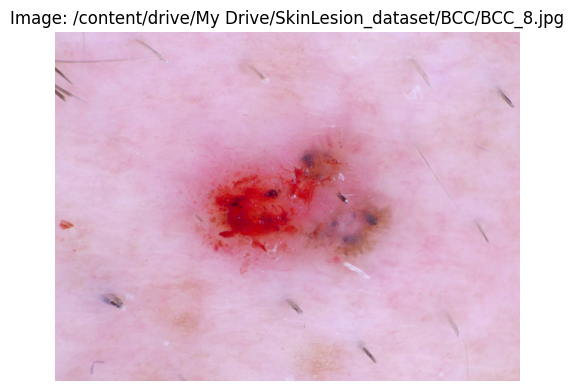

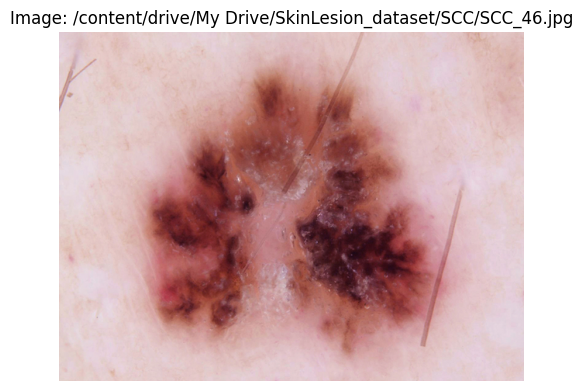

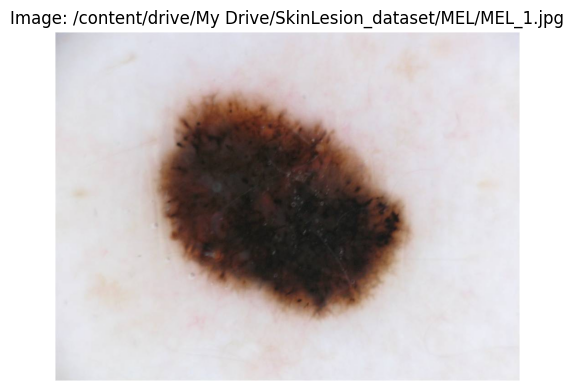

Predicted Classes: ['BCC' 'MEL' 'MEL']


In [ ]:
# SHAP analysis function with pre-extracted features

test_image_paths = [
    '/content/drive/My Drive/SkinLesion_dataset/BCC/BCC_8.jpg',
    '/content/drive/My Drive/SkinLesion_dataset/SCC/SCC_46.jpg',
    '/content/drive/My Drive/SkinLesion_dataset/MEL/MEL_1.jpg'
]
def shap_analysis_with_images(best_estimator, X_train, image_paths, preprocessed_dir):
    # Load preprocessed features from CSV
    selected_features_df_path = os.path.join(preprocessed_dir, 'selected_features.csv')
    selected_features_df = pd.read_csv(selected_features_df_path)

    test_features_list = []
    for img_path in image_paths:
        filename = os.path.basename(img_path).replace('.jpg', '_preprocessed.png')
        feature_row = selected_features_df[selected_features_df['filename'] == filename]

        if not feature_row.empty:
            # Extract the saved features directly
            feature_values = feature_row.drop(columns='filename').values[0]
            test_features_list.append(feature_values)
        else:
            print(f"No features found for image {img_path}")

    test_features_array = np.array(test_features_list)

    # Check feature consistency
    print(f"Features Array Shape: {test_features_array.shape}")
    if test_features_array.size == 0:
        raise ValueError("Extracted features array is empty. Check the features CSV file.")
    if test_features_array.shape[1] != X_train.shape[1]:
        raise ValueError(f"Number of features in test images ({test_features_array.shape[1]}) does not match the number of features used during training ({X_train.shape[1]}).")

    # SHAP explanation
    explainer = shap.KernelExplainer(best_estimator.predict, X_train)
    shap_values = explainer.shap_values(test_features_array)

    # Display SHAP force plots
    for i, (img_path, shap_value) in enumerate(zip(image_paths, shap_values)):
        img = plt.imread(img_path)
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f'Image: {img_path}')
        plt.axis('off')
        plt.show()

        shap.force_plot(explainer.expected_value, shap_value, feature_names=[f'feature_{j}' for j in range(test_features_array.shape[1])])
        plt.title(f'SHAP for {img_path}')
        plt.savefig(f'shap_image_{i}.png')
        plt.close()

    return best_estimator.predict(test_features_array)

# Test specific images and analyze with SHAP
predictions = shap_analysis_with_images(best_model, X_train, test_image_paths, preprocessed_dir)
class_names = label_encoder.inverse_transform(predictions)
print("Predicted Classes:", class_names)